## Prototype selection for nearest neighbor

#### One way to speed up nearest neighbor classification is to replace the training set by a carefully chosen subset of “prototypes” – i.e. instead of keeping the entire training set to use for nearest neighbor classification, carefully choose a small but representative subset to search for nearest neighbors in. Because this set is smaller than the training data, search will be faster and thus so will classification. However, if poor prototypes are chosen, the resulting test accuracy may be much worse. Think of a good strategy for choosing prototypes from the training set, bearing in mind that the ultimate goal is good classification performance on test data. What properties make a set of examples effective for nearest neighbor classification? Can you formalize these properties and use them to select protoypes automatically?

In [96]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle

In [98]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Baseline 

In [99]:
# Extract x_train, y_train, x_test, and y_test from DataLoader
def extract_data(loader):
    x_data, y_data = [], []
    for images, labels in loader:
        x_data.append(images.view(images.size(0), -1).numpy())
        y_data.append(labels.numpy())
    return np.concatenate(x_data), np.concatenate(y_data)

x_train, y_train = extract_data(train_loader)
x_test, y_test = extract_data(test_loader)

In [100]:
def train_knn(x_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(x_train, y_train)
    return knn

def get_random_subset(x, y, size):
    indices = np.random.choice(x.shape[0], size, replace=False)
    return x[indices], y[indices]

def evaluate_knn_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [101]:
sample_sizes = [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]

baseline_accuracies = []

for M in sample_sizes:
    x_subset, y_subset = get_random_subset(x_train, y_train, M)
    knn_model = train_knn(x_subset, y_subset)
    accuracy = evaluate_knn_model(knn_model, x_test, y_test)
    baseline_accuracies.append(accuracy)
    print(f"Baseline accuracy for M={M} => {accuracy}")

    # Save the k-NN model
    model_filename = f"knn_model_M_{M}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(knn_model, model_file)

Baseline accuracy for M=500 => 0.8488
Baseline accuracy for M=1000 => 0.8749
Baseline accuracy for M=2000 => 0.9138
Baseline accuracy for M=5000 => 0.9355
Baseline accuracy for M=10000 => 0.9496
Baseline accuracy for M=15000 => 0.9542
Baseline accuracy for M=20000 => 0.9574
Baseline accuracy for M=25000 => 0.9607


In [102]:
accuracy_filename = "baseline_accuracies.pkl"
with open(accuracy_filename, 'wb') as accuracy_file:
    pickle.dump(baseline_accuracies, accuracy_file)


### KMeans 

In [103]:
def kmeans_1NN(n_clusters, x_train, y_train, x_test, y_test, model_filename):
    try:
        kmeans_model, kmeans_knn_accuracy = pickle.load(open(model_filename, "rb"))
    except FileNotFoundError:
        kmeans_model = KMeans(n_clusters=n_clusters)
        kmeans_model.fit(x_train)

        cluster_distances = []
        for cluster_center in kmeans_model.cluster_centers_:
            distances = []
            for x in x_train:
                distances.append(np.linalg.norm(cluster_center - x))
            cluster_distances.append(distances)

        kmeans_knn_accuracy = []

        for M in [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]:
            subset_x, subset_y = [], []

            num_samples_per_cluster = M // n_clusters

            for cluster_idx in range(n_clusters):
                sorted_indices = np.argsort(cluster_distances[cluster_idx])
                for sample_x in x_train[sorted_indices[:num_samples_per_cluster]]:
                    subset_x.append(sample_x)
                for sample_y in y_train[sorted_indices[:num_samples_per_cluster]]:
                    subset_y.append(sample_y)

            subset_x = np.asarray(subset_x)
            subset_y = np.asarray(subset_y)


            knn_model = KNeighborsClassifier(n_neighbors=1)
            knn_model.fit(subset_x, subset_y)

            y_pred = knn_model.predict(x_test)

            accuracy = accuracy_score(y_test, y_pred)
            kmeans_knn_accuracy.append(accuracy)
            print(f"KMeans + k-NN accuracy for n_clusters={n_clusters} M={M} => {accuracy}")

        pickle.dump((kmeans_model, kmeans_knn_accuracy), open(model_filename, "wb"))

    return kmeans_knn_accuracy


In [104]:
mean_model_filenames = ["model_10.pkl", "model_50.pkl", "model_100.pkl", "model_150.pkl", "model_200.pkl", "model_250.pkl"]

In [105]:
for n_clusters_value, model_filename in zip([10, 50, 100, 150, 200, 250], mean_model_filenames):
    accuracies = kmeans_1NN(n_clusters_value, x_train, y_train, x_test, y_test, model_filename)

KMeans + k-NN accuracy for n_clusters=10 M=500 => 0.686
KMeans + k-NN accuracy for n_clusters=10 M=1000 => 0.7402
KMeans + k-NN accuracy for n_clusters=10 M=2000 => 0.7621
KMeans + k-NN accuracy for n_clusters=10 M=5000 => 0.8172
KMeans + k-NN accuracy for n_clusters=10 M=10000 => 0.8577
KMeans + k-NN accuracy for n_clusters=10 M=15000 => 0.8823
KMeans + k-NN accuracy for n_clusters=10 M=20000 => 0.898
KMeans + k-NN accuracy for n_clusters=10 M=25000 => 0.9144
KMeans + k-NN accuracy for n_clusters=50 M=500 => 0.8448
KMeans + k-NN accuracy for n_clusters=50 M=1000 => 0.8603
KMeans + k-NN accuracy for n_clusters=50 M=2000 => 0.877
KMeans + k-NN accuracy for n_clusters=50 M=5000 => 0.8945
KMeans + k-NN accuracy for n_clusters=50 M=10000 => 0.9146
KMeans + k-NN accuracy for n_clusters=50 M=15000 => 0.9249
KMeans + k-NN accuracy for n_clusters=50 M=20000 => 0.9306
KMeans + k-NN accuracy for n_clusters=50 M=25000 => 0.9348
KMeans + k-NN accuracy for n_clusters=100 M=500 => 0.8806
KMeans + k-

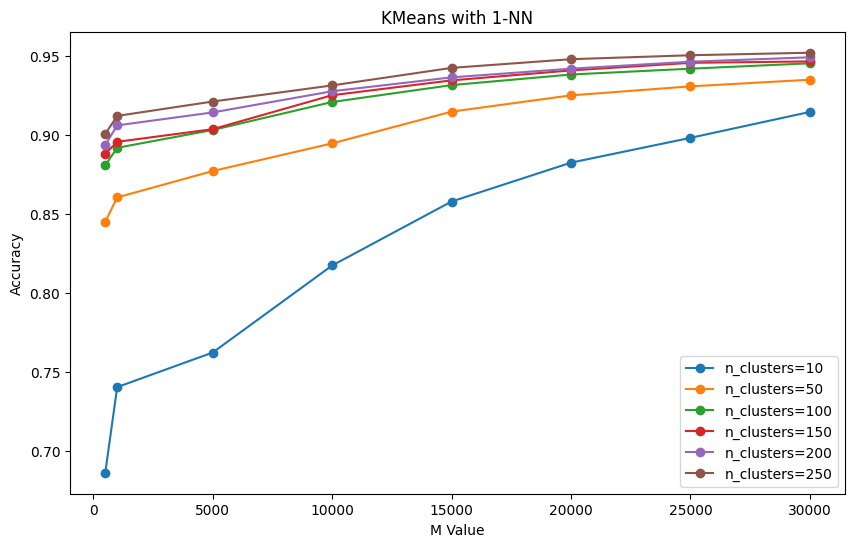

In [106]:
plt.figure(figsize=(10, 6))

for model_filename in mean_model_filenames:
    _, accuracies = pickle.load(open(model_filename, "rb"))
    plt.plot(M_values[:len(accuracies)], accuracies, marker='o', label=f"n_clusters={model_filename.split('_')[1][:-4]}")

plt.title("KMeans with 1-NN")
plt.xlabel("M Value")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### KMedian (Proposed Methodology)

In [110]:
def kmedian_1NN(n_clusters, x_train, y_train, x_test, y_test, model_filename):
    try:
        kmedian_model, kmedian_accuracy = pickle.load(open(model_filename, "rb"))
    except FileNotFoundError:
        kmedian_model = KMeans(n_clusters=n_clusters)
        kmedian_model.fit(x_train)

        kmedian_accuracy = []

        for M in [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]:
            subset_x, subset_y = [], []

            num_samples_per_cluster = M // n_clusters

            for cluster_idx in range(n_clusters):
                if np.any(y_train == cluster_idx):
                    median_values = np.nanmedian(x_train[y_train == cluster_idx], axis=0)

                    # Choose samples closest to the median
                    cluster_data = x_train[y_train == cluster_idx]
                    sorted_indices = np.argsort(np.sum(np.abs(cluster_data - median_values), axis=1))

                    # Form the subset
                    for sample_x in x_train[sorted_indices[:num_samples_per_cluster]]:
                        subset_x.append(sample_x)
                    for sample_y in y_train[sorted_indices[:num_samples_per_cluster]]:
                        subset_y.append(sample_y)

            subset_x = np.asarray(subset_x)
            subset_y = np.asarray(subset_y)

            # Train k-NN model on the subset
            knn_model = KNeighborsClassifier(n_neighbors=1)
            knn_model.fit(subset_x, subset_y)

            # Test the model on the original test data
            y_pred = knn_model.predict(x_test)

            # Calculate accuracy and append to the list
            accuracy = accuracy_score(y_test, y_pred)
            kmedian_accuracy.append(accuracy)
            print(f"Proposed KMedian model accuracy for n_clusters={n_clusters} M={M} => {accuracy}")

        # Save the model and accuracy
        pickle.dump((kmedian_model, kmedian_accuracy), open(model_filename, "wb"))

    return kmedian_accuracy


In [111]:
median_model_filenames = ["model_10_med.pkl", "model_50_med.pkl", "model_100_med.pkl", "model_150_med.pkl", "model_200_med.pkl", "model_250_med.pkl"]

In [112]:
for n_clusters_value, model_filename in zip([10, 50, 100, 150, 200, 250], median_model_filenames):
    accuracies = kmedian_1NN(n_clusters_value, x_train, y_train, x_test, y_test, model_filename)

Proposed KMedian model accuracy for n_clusters=10 M=500 => 0.8568
Proposed KMedian model accuracy for n_clusters=10 M=1000 => 0.8879
Proposed KMedian model accuracy for n_clusters=10 M=2000 => 0.9088
Proposed KMedian model accuracy for n_clusters=10 M=5000 => 0.9262
Proposed KMedian model accuracy for n_clusters=10 M=10000 => 0.9365
Proposed KMedian model accuracy for n_clusters=10 M=15000 => 0.9384
Proposed KMedian model accuracy for n_clusters=10 M=20000 => 0.9387
Proposed KMedian model accuracy for n_clusters=10 M=25000 => 0.9388
Proposed KMedian model accuracy for n_clusters=50 M=500 => 0.7067
Proposed KMedian model accuracy for n_clusters=50 M=1000 => 0.8079
Proposed KMedian model accuracy for n_clusters=50 M=2000 => 0.8466
Proposed KMedian model accuracy for n_clusters=50 M=5000 => 0.8879
Proposed KMedian model accuracy for n_clusters=50 M=10000 => 0.9088
Proposed KMedian model accuracy for n_clusters=50 M=15000 => 0.9199
Proposed KMedian model accuracy for n_clusters=50 M=20000 

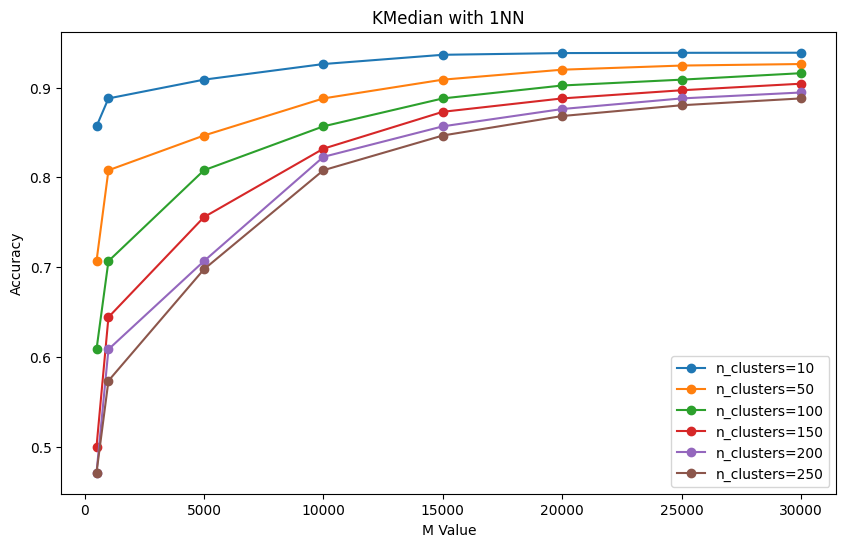

In [113]:
plt.figure(figsize=(10, 6))

for model_filename in median_model_filenames:
    _, accuracies = pickle.load(open(model_filename, "rb"))
    plt.plot(M_values[:len(accuracies)], accuracies, marker='o', label=f"n_clusters={model_filename.split('_')[1]}")

plt.title("KMedian with 1NN")
plt.xlabel("M Value")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

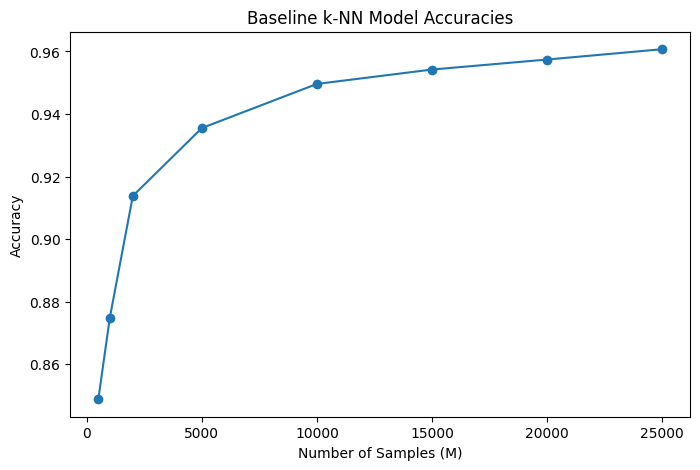

In [114]:
# Load accuracies
accuracy_filename = "baseline_accuracies.pkl"
with open(accuracy_filename, 'rb') as accuracy_file:
    baseline_accuracies = pickle.load(accuracy_file)

# Values of M
sample_sizes = [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, baseline_accuracies, marker='o')
plt.title("Baseline k-NN Model Accuracies")
plt.xlabel("Number of Samples (M)")
plt.ylabel("Accuracy")
plt.show()


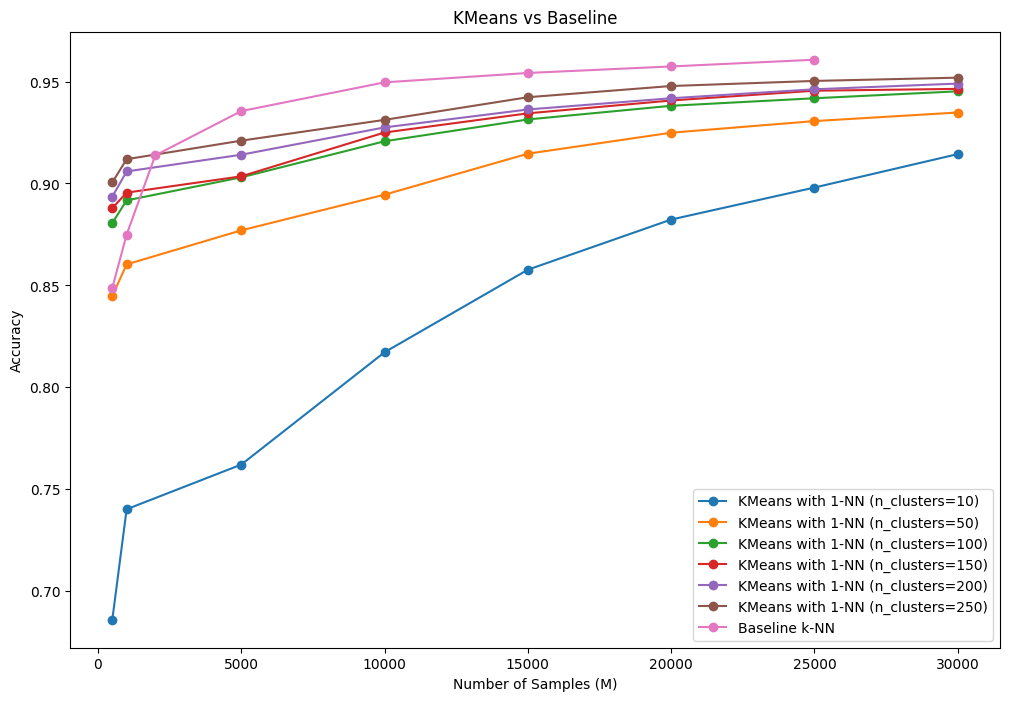

In [115]:
mean_model_filenames = ["model_10.pkl", "model_50.pkl", "model_100.pkl", "model_150.pkl", "model_200.pkl", "model_250.pkl"]

plt.figure(figsize=(12, 8))

for model_filename in mean_model_filenames:
    _, accuracies = pickle.load(open(model_filename, "rb"))
    plt.plot(M_values[:len(accuracies)], accuracies, marker='o', label=f"KMeans with 1-NN (n_clusters={model_filename.split('_')[1][:-4]})")

# Load baseline k-NN accuracies
accuracy_filename = "baseline_accuracies.pkl"
with open(accuracy_filename, 'rb') as accuracy_file:
    baseline_accuracies = pickle.load(accuracy_file)

# Values of M for baseline k-NN
sample_sizes = [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]

# Plot baseline k-NN accuracies
plt.plot(sample_sizes, baseline_accuracies, marker='o', label="Baseline k-NN")

plt.title("KMeans vs Baseline")
plt.xlabel("Number of Samples (M)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


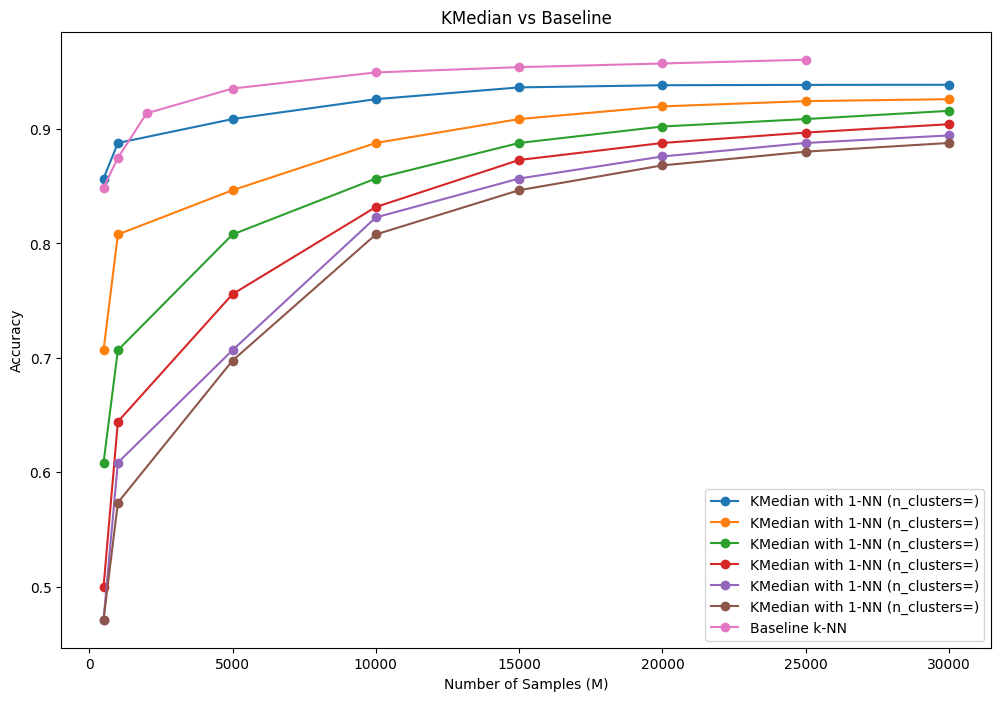

In [116]:
median_model_filenames = ["model_10_med.pkl", "model_50_med.pkl", "model_100_med.pkl", "model_150_med.pkl", "model_200_med.pkl", "model_250_med.pkl"]

plt.figure(figsize=(12, 8))

for model_filename in median_model_filenames:
    _, accuracies = pickle.load(open(model_filename, "rb"))
    plt.plot(M_values[:len(accuracies)], accuracies, marker='o', label=f"KMedian with 1-NN (n_clusters={model_filename.split('_')[1][:-4]})")

# Load baseline k-NN accuracies
accuracy_filename = "baseline_accuracies.pkl"
with open(accuracy_filename, 'rb') as accuracy_file:
    baseline_accuracies = pickle.load(accuracy_file)

# Values of M for baseline k-NN
sample_sizes = [500, 1000, 2000, 5000, 10000, 15000, 20000, 25000]

# Plot baseline k-NN accuracies
plt.plot(sample_sizes, baseline_accuracies, marker='o', label="Baseline k-NN")

plt.title("KMedian vs Baseline")
plt.xlabel("Number of Samples (M)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()